In [1]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Core libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_1samp, anderson, norm

# Machine Learning models and preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import label_binarize

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
    roc_curve,
    auc
)

# XGBoost model
from xgboost import XGBClassifier
import warnings

# Suppress all warnings including UserWarnings and FutureWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")


/kaggle/input/Original_data_with_more_rows.csv
/kaggle/input/Expanded_data_with_more_features.csv


# Project Introduction

Git Hub repository- https://github.com/krymar18/supervised_final

## Problem Statement

This supervised learning project aims to predict student performance based on various demographic and behavioral features. The original goal was to predict the average test score of each student. However, due to the categorical nature of most features and the distribution of scores, I reframed the problem as a classification task. Students are categorized into three performance tiers—underperformers, average performers, and overperformers—based on their average scores. This classification approach aligns better with the data structure and enhances model interpretability.

## Learning Type and Task

This is a **supervised learning** project, specifically a **classification task**. The model is trained on labeled data where the target variable is the performance category derived from average test scores.

## Project Goal

The goal is to build a predictive model that accurately classifies students into performance tiers using features such as gender, parental education, lunch type, test preparation, and study habits. This can help educators identify students who may need additional support or resources.

# Data Description

## Data Source
The dataset is publicly available on Kaggle: https://www.kaggle.com/datasets/desalegngeb/students-exam-scores

## Dataset Overview

- **Number of Samples (Rows):** 30641
- **Number of Features (Columns):** 15
- **Categorical Features:** 10
- **Numerical Features:** 5

### Key Features

Some of the important features in the dataset include:

- `Gender`: Student's gender  
- `EthnicGroup`: Ethnic background  
- `ParentEduc`: Highest education level of parents  
- `LunchType`: Type of lunch (standard or free/reduced)  
- `TestPrep`: Completion status of test preparation course  
- `PracticeSport`: Frequency of sports practice  
- `WklyStudyHours`: Weekly study hours  
- `MathScore`, `ReadingScore`, `WritingScore`: Individual test scores. These features are used to derive the average score and classify students into performance categories.


In [2]:
df = pd.read_csv("/kaggle/input/Expanded_data_with_more_features.csv")
# Drop unnamed index column if present
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df.shape

(30641, 14)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  object 
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  object 
 3   LunchType            30641 non-null  object 
 4   TestPrep             28811 non-null  object 
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  object 
 7   IsFirstChild         29737 non-null  object 
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  object 
 10  WklyStudyHours       29686 non-null  object 
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 3.3+ MB


In [4]:
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75


### Evaluating for NAs

While several columns contain missing values, none exceed 10%, and most are well below that threshold. For models like linear regression that require complete df and numeric encoding, I may exclude or impute these fields. However, for tree-based models such as Random Forest or Gradient Boosting, which are more robust to missing or categorical df, I plan to retain them to preserve feature richness

In [5]:
# Cretes summary table for the NA values
na_counts = df.isna().sum()
na_percentage = (na_counts / len(df)) * 100

na_summary = pd.DataFrame({
    'Missing Values': na_counts,
    'Percentage (%)': na_percentage.round(2)
})

na_summary = na_summary[na_summary['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)
na_summary

,Missing Values,Percentage (%)
TransportMeans,3134,10.23
ParentEduc,1845,6.02
EthnicGroup,1840,6.01
TestPrep,1830,5.97
NrSiblings,1572,5.13
ParentMaritalStatus,1190,3.88
WklyStudyHours,955,3.12
IsFirstChild,904,2.95
PracticeSport,631,2.06


# Data Cleaning and Preprocessing

This section prepars the dataset for supervised machine learning by encoding categorical variables, handling missing values, and ensuring all features are in a numeric format suitable for modeling.

## Preliminary examination

The following section visualizes each column to better understand the makeup of the column, distribution and NA counts. This will further guide the cleaning strategy.

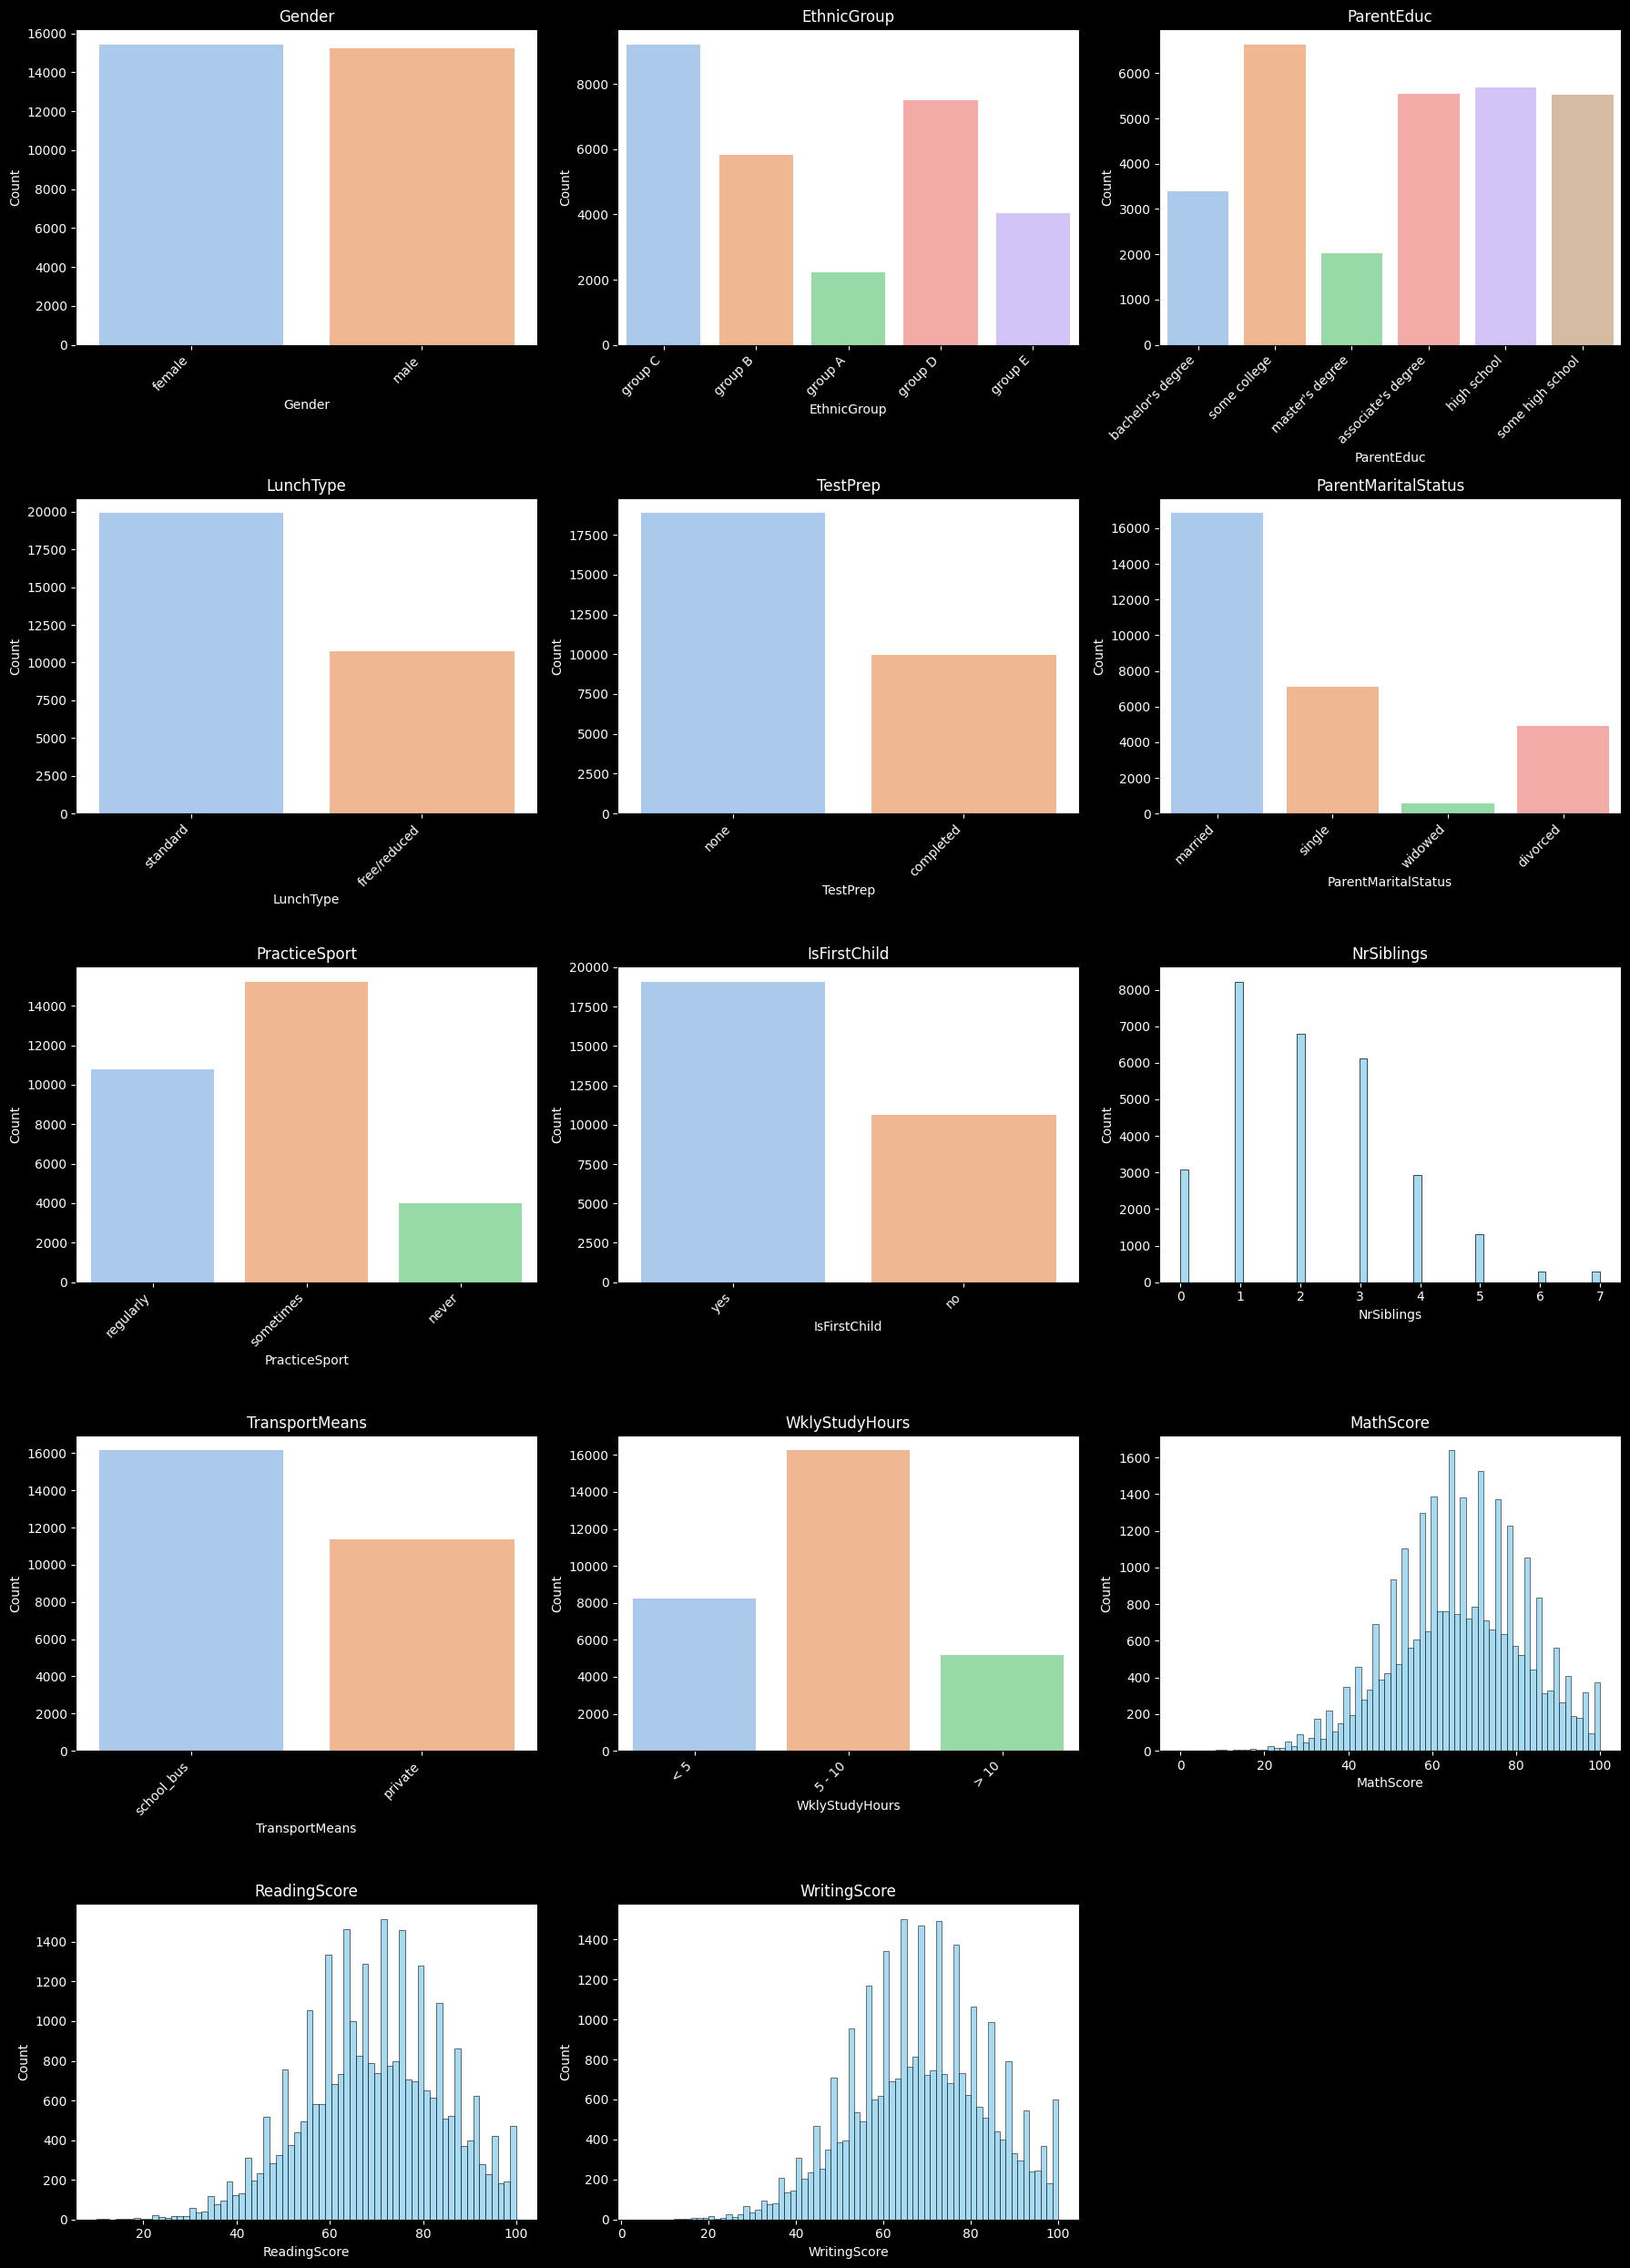

In [6]:

# Determine column types
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Set up the plot grid
total_cols = len(df.columns)
cols_per_row = 3
rows = (total_cols + cols_per_row - 1) // cols_per_row

# Create subplots
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 5 * rows))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(df.columns):
    ax = axes[i]
    if col in numeric_cols:
        sns.histplot(df[col].dropna(), kde=False, ax=ax, color='skyblue')
    else:
        sns.countplot(x=col, data=df, ax=ax, palette='pastel')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(col, fontsize=12, color='white')
    ax.set_xlabel(col, color='white')
    ax.set_ylabel('Count', color='white')
    ax.tick_params(colors='white')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Set background color
fig.patch.set_facecolor('black')
plt.tight_layout()
plt.show()


When examining the distributions of MathScore, ReadingScore, and WritingScore, we observe a number of values that might initially appear as outliers. However, these are likely not true anomalies but rather natural results of the test's scoring structure.

For example, a score of 68 is functionally equivalent to a score of 67 in most grading systems—both fall within the same performance band. Therefore, treating them as distinct in a histogram with narrow bins may exaggerate minor differences.

To better reflect meaningful groupings and reduce visual noise, we aggregate scores into broader bins. This approach helps us focus on performance trends rather than individual score fluctuations.


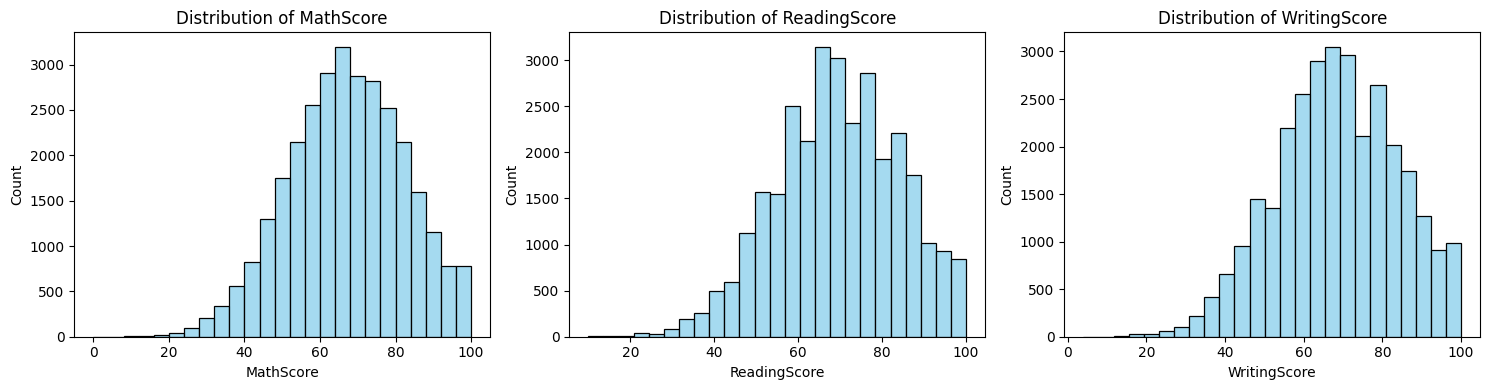

In [7]:

# Select only the score columns
score_columns = ['MathScore', 'ReadingScore', 'WritingScore']

# Set up the plot
plt.figure(figsize=(15, 4))

# Plot each score column with reduced number of bins
for i, col in enumerate(score_columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col].dropna(), bins=25, kde=False, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()



## Data Cleaning Strategy

The preprocessing strategy was guided by three core principles:

1. **Preserving Semantic Meaning**: Categorical variables were encoded in ways that retained their interpretive value—ordinal variables were mapped to ordered scales, while nominal variables were encoded using categorical codes or binary mappings where appropriate.

2. **Imputing Missing Values Thoughtfully**: Missing values were handled using statistical imputation:
   - **Mode** was used for categorical variables to preserve the most common category.
   - **Median** was used for numeric variables to reduce the influence of outliers.
   - For binary or ordinal variables, domain-informed defaults were applied (e.g., assuming 'none' for missing test prep).

3. **No Column Removal**: No columns were dropped due to missing values. All columns had less than 10% missing data, making imputation a more appropriate and data-preserving strategy.


##  Preprocessing Steps

### 1. Gender Encoding
- **Transformation**: 'female' → 1, 'male' → 0
- **Justification**: Binary encoding for binary categorical variable.

### 2. Parent Education Level
- **Transformation**: Ordinal mapping from "some high school" (1) to "master's degree" (6).
- **Missing Values**: Filled with mode to reflect the most common education level.
- **Justification**: Reflects educational hierarchy and preserves ordinal meaning.

### 3. Weekly Study Hours
- **Transformation**: Categorical ranges converted to numeric midpoints.
- **Missing Values**: Filled with median to reduce outlier influence.
- **Justification**: Enables numerical analysis of study time.

### 4. Is First Child
- **Transformation**: 'yes' → 1, 'no' → 0
- **Justification**: Binary encoding for binary variable.

### 5. Practice Sport Frequency
- **Transformation**: 'never' → 0, 'sometimes' → 1, 'regularly' → 2
- **Justification**: Ordinal encoding for frequency levels.

### 6. Test Preparation
- **Transformation**: 'none' → 0, 'completed' → 1
- **Missing Values**: Assumed 'none' for missing entries.
- **Justification**: Reflects preparation level.

### 7. Lunch Type
- **Transformation**: 'free/reduced' → 0, 'standard' → 1
- **Justification**: Binary encoding reflecting socioeconomic status.

### 8. Parent Marital Status
- **Transformation**: Encoded as categorical codes.
- **Missing Values**: Filled with mode.
- **Justification**: Nominal categorical variable.

### 9. Transport Means
- **Transformation**: Encoded as categorical codes.
- **Missing Values**: Filled with mode.
- **Justification**: Nominal categorical variable.

### 10. Ethnic Group
- **Transformation**: Encoded as categorical codes.
- **Missing Values**: Filled with mode.
- **Justification**: Nominal categorical variable.

### 11. Number of Siblings
- **Transformation**: Ensured numeric format.
- **Missing Values**: Filled with median.
- **Justification**: Numeric feature for modeling.




In [8]:
import pandas as pd
import numpy as np


# 1. Encode 'Gender' as binary
df['Gender'] = df['Gender'].map({'female': 1, 'male': 0})

# 2. Map 'ParentEduc' to ordinal values and fill NAs with mode
education_mapping = {
    "some high school": 1,
    "high school": 2,
    "associate's degree": 3,
    "some college": 4,
    "bachelor's degree": 5,
    "master's degree": 6
}
df['ParentEduc'] = df['ParentEduc'].map(education_mapping)
df['ParentEduc'] = df['ParentEduc'].fillna(df['ParentEduc'].mode()[0])

# 3. Convert 'WklyStudyHours' ranges to numeric midpoints and fill NAs with median
study_hours_mapping = {
    '< 5': 2.5,
    '5 - 10': 7.5,
    '> 10': 12.5
}
df['WklyStudyHours'] = df['WklyStudyHours'].map(study_hours_mapping)
df['WklyStudyHours'] = df['WklyStudyHours'].fillna(df['WklyStudyHours'].median())

# 4. Encode 'IsFirstChild' as binary
df['IsFirstChild'] = df['IsFirstChild'].map({'yes': 1, 'no': 0}).fillna(1)

# 5. Encode 'PracticeSport' frequency ordinally
sport_mapping = {
    'never': 0,
    'sometimes': 1,
    'regularly': 2
}
df['PracticeSport'] = df['PracticeSport'].map(sport_mapping).fillna(0)

# 6. Encode 'TestPrep' as ordinal and fill NAs with 0 (assume 'none')
test_prep_mapping = {
    'none': 0,
    'completed': 1
}
df['TestPrep'] = df['TestPrep'].map(test_prep_mapping)
df['TestPrep'] = df['TestPrep'].fillna(0)

# 7. Encode 'LunchType' as binary
lunch_mapping = {
    'free/reduced': 0,
    'standard': 1
}
df['LunchType'] = df['LunchType'].map(lunch_mapping)

# 8. Encode 'ParentMaritalStatus' as categorical codes and fill NAs with mode
df['ParentMaritalStatus'] = df['ParentMaritalStatus'].astype('category').cat.codes
df['ParentMaritalStatus'] = df['ParentMaritalStatus'].replace(-1, pd.NA)
df['ParentMaritalStatus'] = df['ParentMaritalStatus'].fillna(df['ParentMaritalStatus'].mode()[0]).astype(int)

# 9. Encode 'TransportMeans' as categorical codes and fill NAs with mode
df['TransportMeans'] = df['TransportMeans'].astype('category').cat.codes
df['TransportMeans'] = df['TransportMeans'].replace(-1, pd.NA)
df['TransportMeans'] = df['TransportMeans'].fillna(df['TransportMeans'].mode()[0]).astype(int)

# 10. Encode 'EthnicGroup' as categorical codes and fill NAs with mode
df['EthnicGroup'] = df['EthnicGroup'].astype('category').cat.codes
df['EthnicGroup'] = df['EthnicGroup'].replace(-1, pd.NA)
df['EthnicGroup'] = df['EthnicGroup'].fillna(df['EthnicGroup'].mode()[0]).astype(int)

# 11. Ensure 'NrSiblings' is numeric and fill NAs with median
df['NrSiblings'] = pd.to_numeric(df['NrSiblings'], errors='coerce')
df['NrSiblings'] = df['NrSiblings'].fillna(df['NrSiblings'].median())

# Confirm all columns are numeric
all_numeric = df.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all()

# Output confirmation
print("All columns numeric:", all_numeric)
print(df.dtypes)


All columns numeric: True
Gender                   int64
EthnicGroup              int64
ParentEduc             float64
LunchType                int64
TestPrep               float64
ParentMaritalStatus      int64
PracticeSport          float64
IsFirstChild           float64
NrSiblings             float64
TransportMeans           int64
WklyStudyHours         float64
MathScore                int64
ReadingScore             int64
WritingScore             int64
dtype: object


In [9]:
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,1,2,5.0,1,0.0,1,2.0,1.0,3.0,1,2.5,71,71,74
1,1,2,4.0,1,0.0,1,1.0,1.0,0.0,1,7.5,69,90,88
2,1,1,6.0,1,0.0,2,1.0,1.0,4.0,1,2.5,87,93,91
3,0,0,3.0,0,0.0,1,0.0,0.0,1.0,1,7.5,45,56,42
4,0,2,4.0,1,0.0,1,1.0,1.0,0.0,1,7.5,76,78,75


# EDA

## Coliniarity of Test Scores for different subjects

A pair plot of `MathScore`, `ReadingScore`, and `WritingScore` reveals strong colinearity—students who score high in one subject tend to score high in others. This suggests the scores reflect a shared underlying ability rather than independent traits.

Including all three as separate features could introduce redundancy, leading to:
- **Multicollinearity**, which distorts feature importance.
- **Overfitting**, where the model captures noise.
- **Skewed predictions**, especially in linear models.


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_35/184868188.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


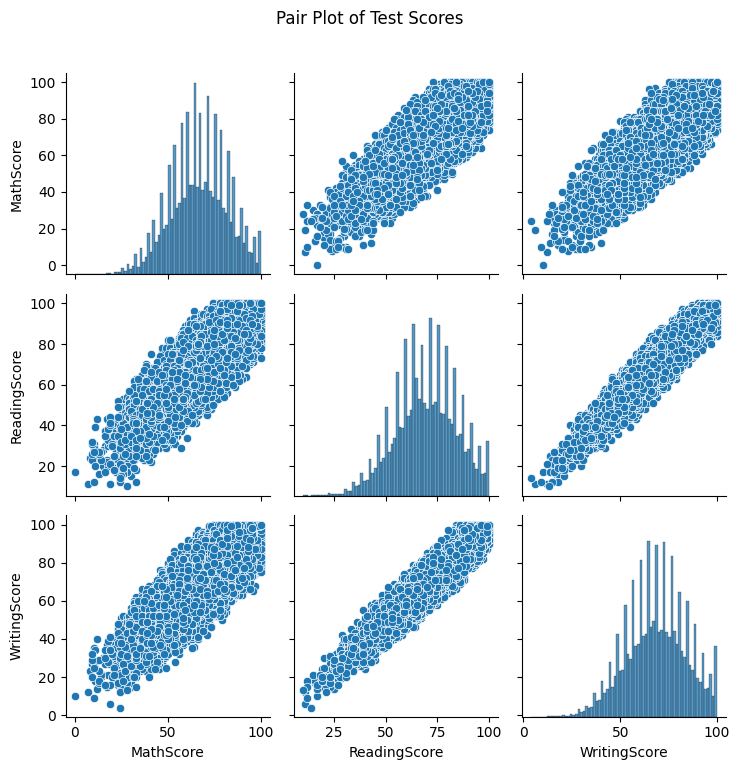

In [10]:
df_scores = df[['MathScore', 'ReadingScore', 'WritingScore']].dropna()
# Pair plot
sns.pairplot(df_scores)
plt.suptitle("Pair Plot of Test Scores", y=1.02)
plt.tight_layout()
plt.show()

### Addressing Score Collinearity with a Composite Feature

To address the strong collinearity observed between `MathScore`, `ReadingScore`, and `WritingScore`, we will use a single composite feature: the **average score**.

This decision is supported by the distribution plots below, which show that:
- All three subject scores follow approximately similar distributions.
- The distribution of the average score significantly overlaps with each individual subject score.

This overlap suggests that the average score captures the shared variance across subjects, making it a suitable and more compact representation of student performance.


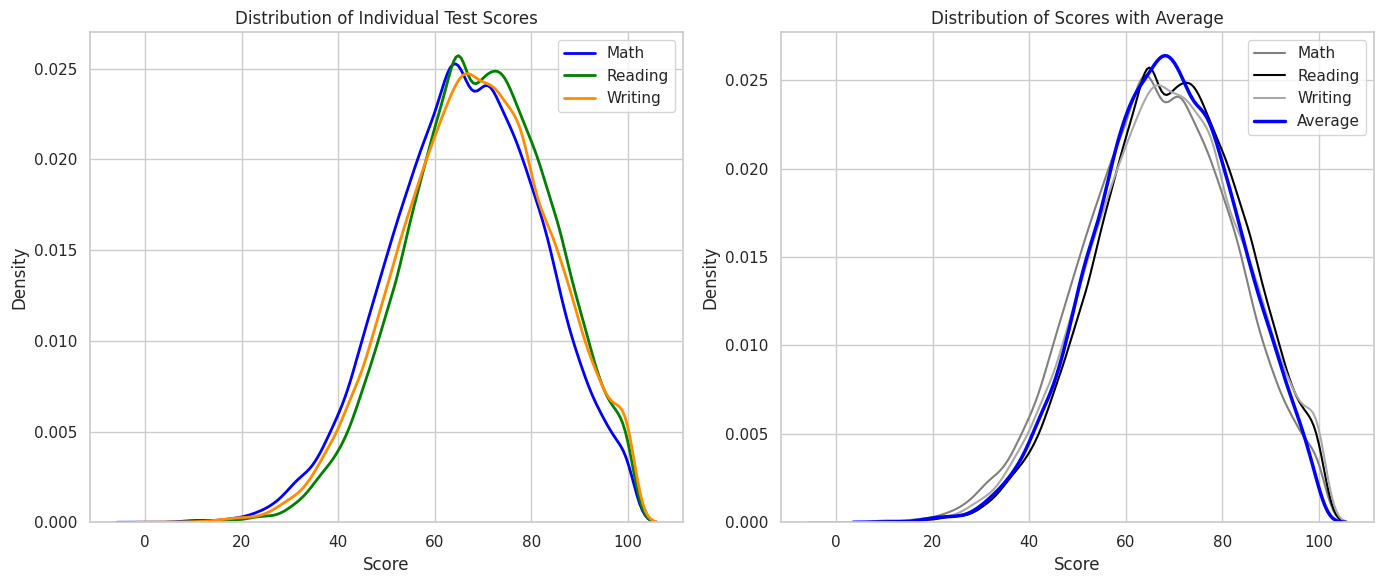

In [11]:

# Calculate average score
df['AverageScore'] = df[['MathScore', 'ReadingScore', 'WritingScore']].mean(axis=1)

# Set plot style
sns.set(style="whitegrid")

# Create side-by-side KDE plots with swapped positions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: only individual scores
sns.kdeplot(df['MathScore'], label='Math', color='blue', linewidth=2, ax=axes[0])
sns.kdeplot(df['ReadingScore'], label='Reading', color='green', linewidth=2, ax=axes[0])
sns.kdeplot(df['WritingScore'], label='Writing', color='darkorange', linewidth=2, ax=axes[0])
axes[0].set_title('Distribution of Individual Test Scores')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Density')
axes[0].legend()

# Right plot: includes AverageScore
sns.kdeplot(df['MathScore'], color='gray', linewidth=1.5, label='Math', ax=axes[1])
sns.kdeplot(df['ReadingScore'], color='black', linewidth=1.5, label='Reading', ax=axes[1])
sns.kdeplot(df['WritingScore'], color='darkgray', linewidth=1.5, label='Writing', ax=axes[1])
sns.kdeplot(df['AverageScore'], color='blue', linewidth=2.5, label='Average', ax=axes[1])
axes[1].set_title('Distribution of Scores with Average')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()


### Chosing Classification model over the linear regression.

While predicting the average score directly using linear regression might seem intuitive, it is not ideal for this dataset. The majority of our features are **categorical**, and linear regression assumes continuous, linearly related predictors. Using regression in this context could lead to poor model fit due to categorical inputs and misleading coefficients and predictions.

### Determing Performance Tier for classification task.

Instead of predicting a continuous score, we will **classify students into three performance tiers** based on their average score:
- **Bottom 25%**: Underperformers
- **Middle 50%**: Average performers
- **Top 25%**: High performers

To define the score thresholds for these categories, we will apply **hypothesis testing** to ensure statistical significance. This approach helps eliminate the risk of misclassifying students due to random variation or bad luck on a single test.


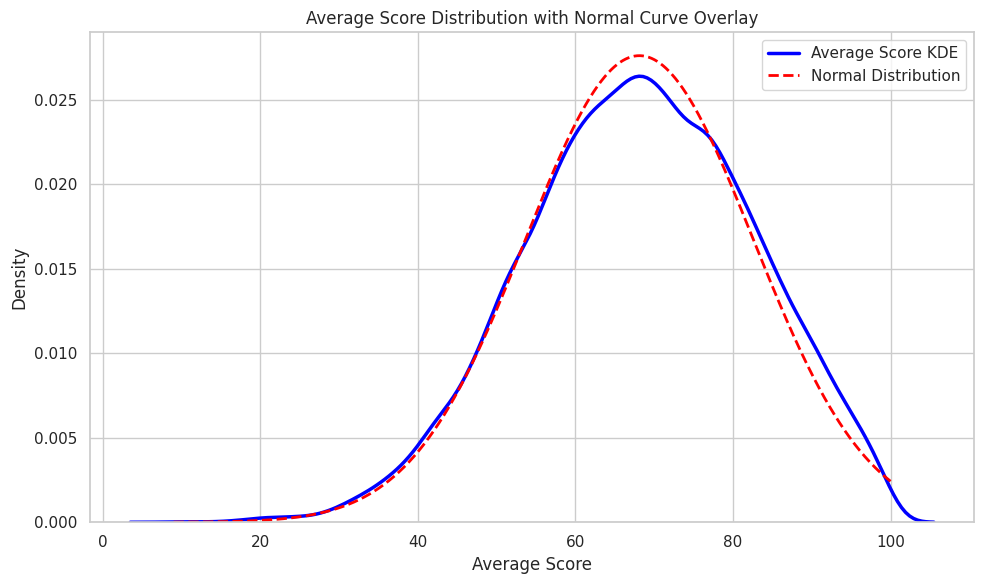

In [12]:


# Compute mean and standard deviation
mean_avg = df['AverageScore'].mean()
std_avg = df['AverageScore'].std()

# Set plot style
sns.set(style="whitegrid")

# Plot KDE of average scores
plt.figure(figsize=(10, 6))
sns.kdeplot(df['AverageScore'], color='blue', linewidth=2.5, label='Average Score KDE')

# Overlay normal distribution curve
x_vals = np.linspace(df['AverageScore'].min(), df['AverageScore'].max(), 1000)
normal_curve = norm.pdf(x_vals, mean_avg, std_avg)
plt.plot(x_vals, normal_curve, color='red', linestyle='--', linewidth=2, label='Normal Distribution')

# Customize plot
plt.title('Average Score Distribution with Normal Curve Overlay')
plt.xlabel('Average Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


### Examining Normality assumtion for Average Scores

Visually, the distribution of average test scores resembles a bell curve, suggesting it may follow a normal distribution. To confirm this, I will apply the **Anderson-Darling Normality Test**.The Anderson-Darling test evaluates whether a sample comes from a specific distribution—in this case, the normal distribution—by comparing the empirical cumulative distribution of the data to that of the expected normal curve.This test is particularly useful because it gives more weight to the tails of the distribution, making it sensitive to deviations from normality.

Confirming normality is critical for choosing the correct statistical test:
- If the data is normally distributed, we can use **z-scores** for hypothesis testing.
- If not, we must rely on **t-scores**, which are more robust for smaller or non-normal samples.

This distinction ensures that our classification thresholds (e.g., bottom 25%, top 25%) are statistically sound and not biased by incorrect distributional assumptions.

In [13]:

result = anderson(df['AverageScore'], dist='norm')
ad_statistic = result.statistic
critical_value_5pct = result.critical_values[2]  # 5% significance level

print(f"Test Statistic: {ad_statistic:.3f}")
print(f"Critical Value @ 5%: {critical_value_5pct:.3f}")
print("Conclusion:", "Reject normality" if ad_statistic > critical_value_5pct else "Fail to reject normality")


Test Statistic: 19.789
Critical Value @ 5%: 0.787
Conclusion: Reject normality


After applying the Anderson-Darling test, we found sufficient evidence to reject the assumption that average scores follow a normal distribution. This means we cannot rely on z-scores, which assume normality and known population variance. Instead, we will use **t-tests**, which are more appropriate for small or non-normally distributed samples and allow us to test whether the bottom and top quartiles differ significantly from the population mean.

The code below calculat the 25th and 75th percentile thresholds, and uses one-sided t-tests to determine whether the bottom and top quartiles are statistically different from the overall mean. It then assigns students to performance categories and visualizes the results.

This approach ensures that our classification into underperformers, average performers, and overperformers is statistically justified and not based on arbitrary cutoffs.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: Futu

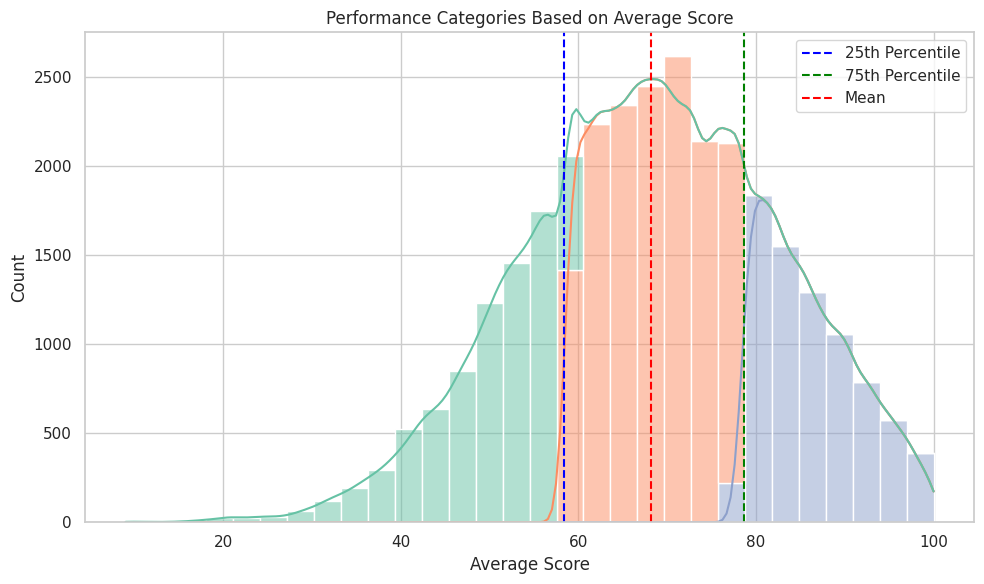

Population Mean Score: 68.12
25th Percentile Threshold: 58.33
75th Percentile Threshold: 78.67
\nBottom 25% t-statistic: -222.47, p-value: 0.0000
Top 25% t-statistic: 287.16, p-value: 0.0000


In [14]:

# Drop rows with missing average scores
df = df.dropna(subset=['AverageScore'])

# Calculate thresholds
lower_threshold = df['AverageScore'].quantile(0.25)
upper_threshold = df['AverageScore'].quantile(0.75)
mean_score = df['AverageScore'].mean()

# Subsets
bottom_25 = df[df['AverageScore'] <= lower_threshold]['AverageScore']
top_25 = df[df['AverageScore'] >= upper_threshold]['AverageScore']

# One-sided t-tests
t_stat_bottom, p_val_bottom = ttest_1samp(bottom_25, popmean=mean_score, alternative='less')
t_stat_top, p_val_top = ttest_1samp(top_25, popmean=mean_score, alternative='greater')

# Assign performance categories
def categorize(score):
    if score <= lower_threshold:
        return 0  # Underperformer
    elif score >= upper_threshold:
        return 2  # Overperformer
    else:
        return 1  # Average

df['PerformanceCategory'] = df['AverageScore'].apply(categorize)

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='AverageScore', kde=True, bins=30, hue='PerformanceCategory', palette='Set2', multiple='stack')
plt.axvline(lower_threshold, color='blue', linestyle='--', label='25th Percentile')
plt.axvline(upper_threshold, color='green', linestyle='--', label='75th Percentile')
plt.axvline(mean_score, color='red', linestyle='--', label='Mean')
plt.title('Performance Categories Based on Average Score')
plt.xlabel('Average Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Print results
print(f"Population Mean Score: {mean_score:.2f}")
print(f"25th Percentile Threshold: {lower_threshold:.2f}")
print(f"75th Percentile Threshold: {upper_threshold:.2f}")
print(f"\\nBottom 25% t-statistic: {t_stat_bottom:.2f}, p-value: {p_val_bottom:.4f}")
print(f"Top 25% t-statistic: {t_stat_top:.2f}, p-value: {p_val_top:.4f}")


Assigning Performance Categories
We assign numeric labels:

0: Underperformer
1: Average Performer
2: Overperformer

Thus, students scoring in the bottom 25% are statistically significantly underperforming.Students scoring in the top 25% are statistically significantly overperforming.
This validates our strategy to use percentile-based thresholds for classification. These boundaries are not arbitrary—they are statistically grounded and suitable for supervised learning tasks.Below is the final examination of the disstribution of different features now based on assigned categories.

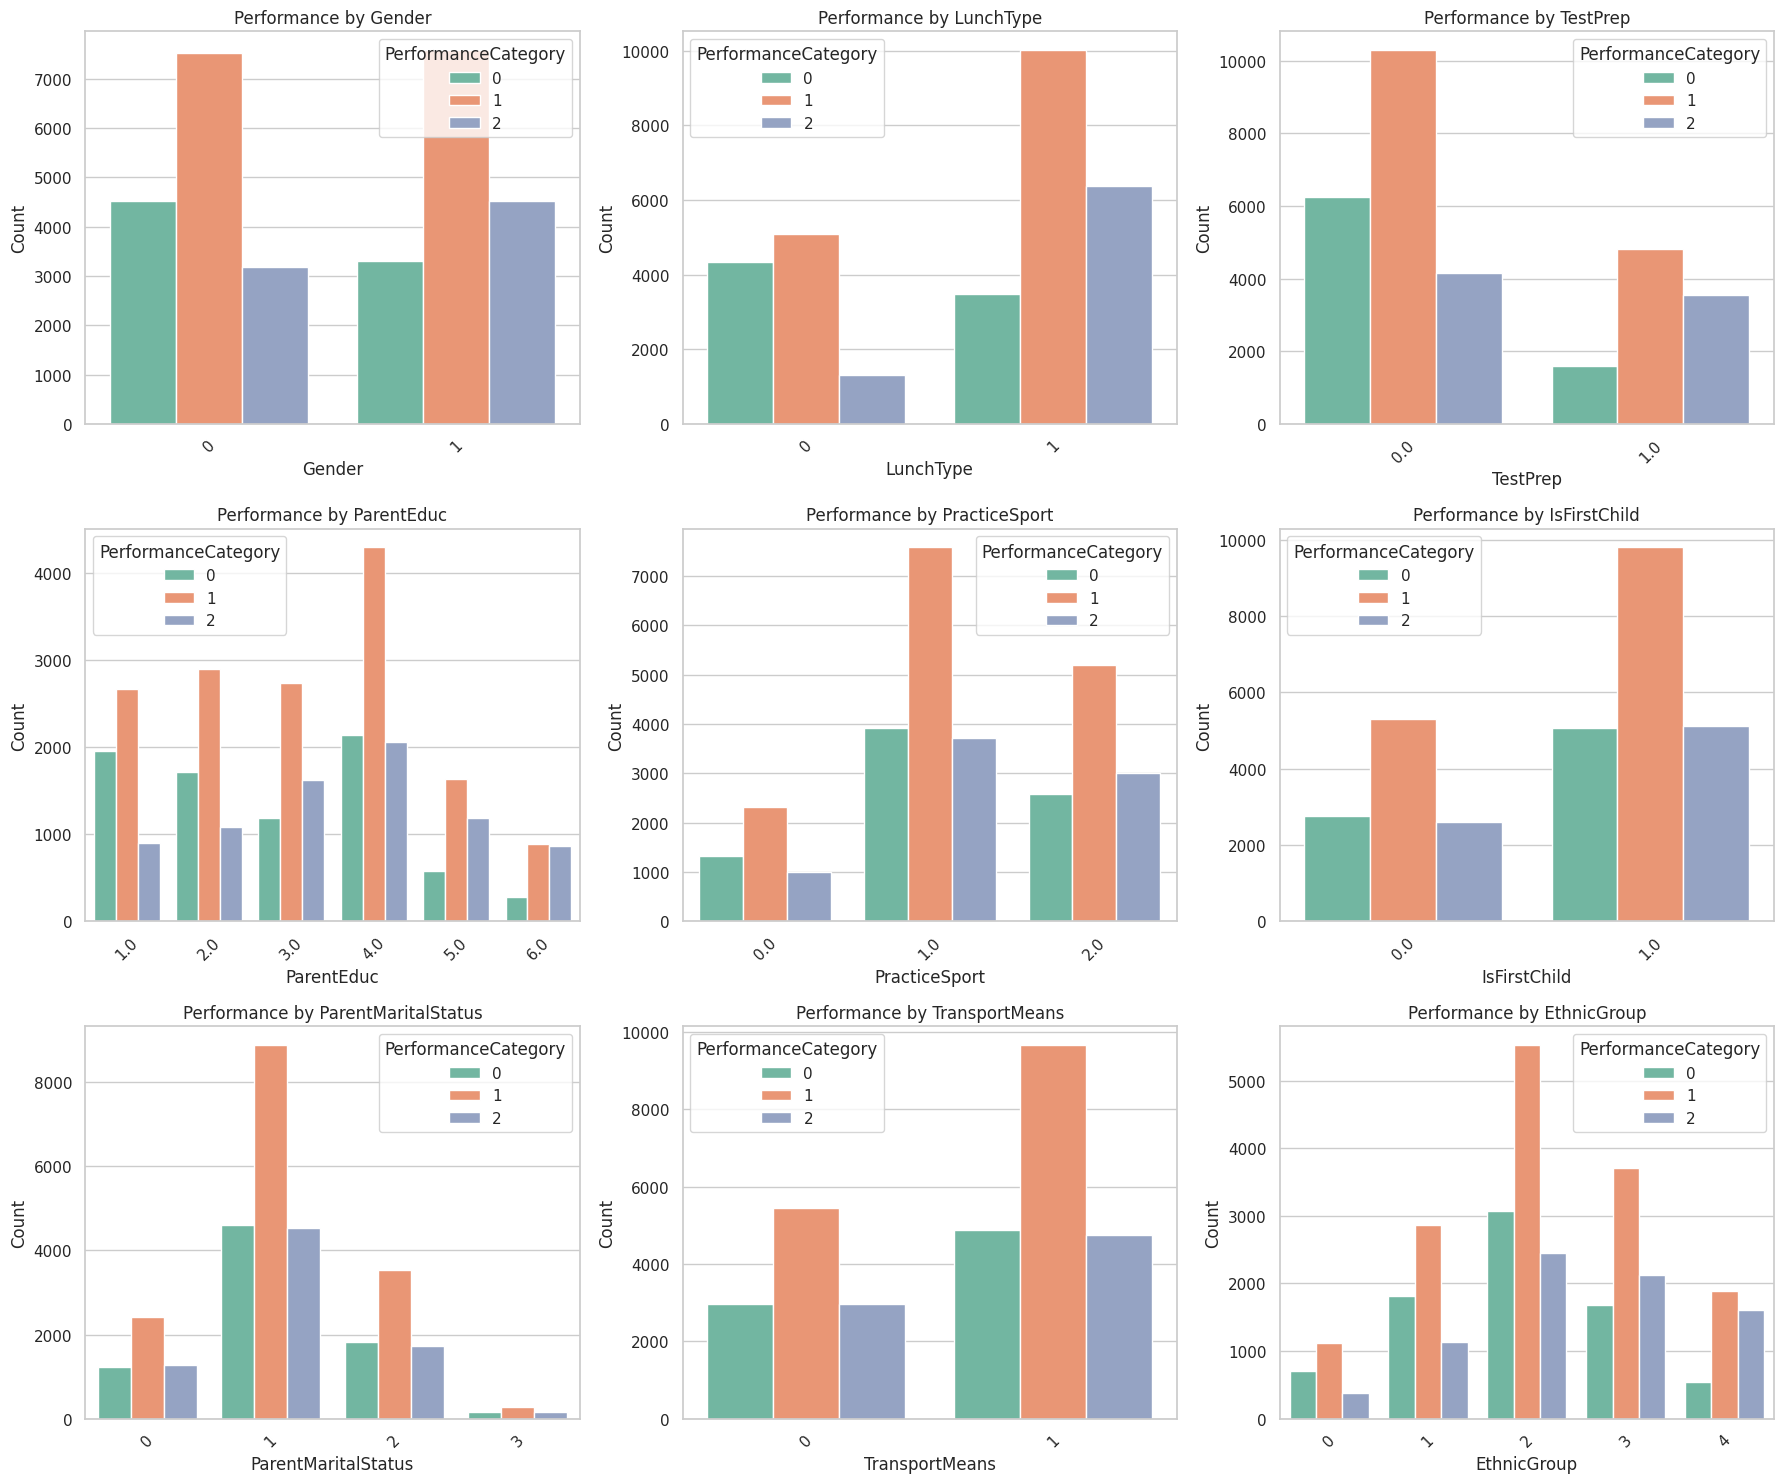

In [15]:

# Select categorical columns to analyze
categorical_columns = ['Gender', 'LunchType', 'TestPrep', 'ParentEduc', 'PracticeSport',
                       'IsFirstChild', 'ParentMaritalStatus', 'TransportMeans', 'EthnicGroup']

# Set up the plot grid
cols_per_row = 3
rows = (len(categorical_columns) + cols_per_row - 1) // cols_per_row
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 5 * rows))
axes = axes.flatten()

# Plot each categorical variable against PerformanceCategory
for i, col in enumerate(categorical_columns):
    sns.countplot(data=df, x=col, hue='PerformanceCategory', ax=axes[i], palette='Set2')
    axes[i].set_title(f'Performance by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



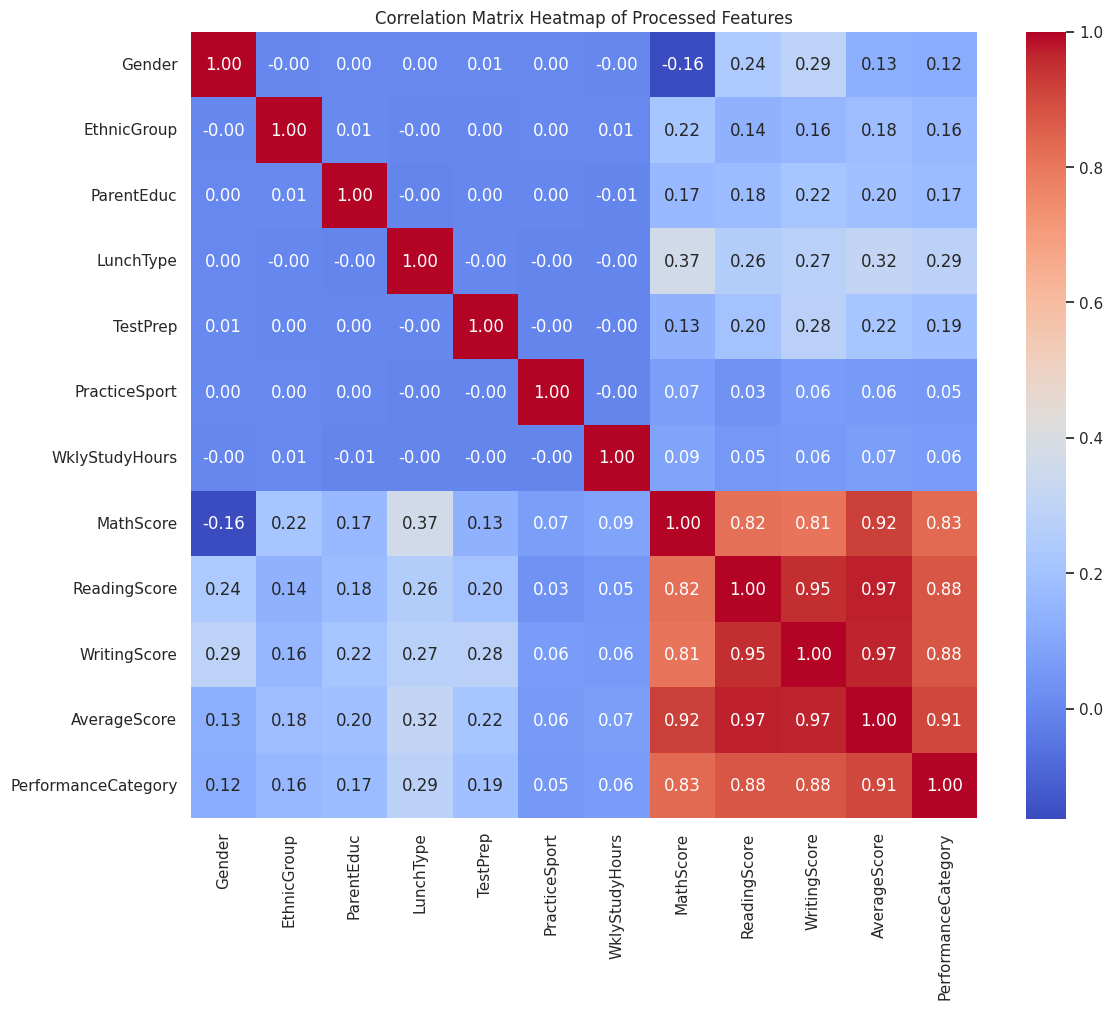

In [16]:

#droping columns that had 0 correlation to achieve a cleaner plot
sample_df = df.drop(columns=['ParentMaritalStatus', 'TransportMeans', 'IsFirstChild', 'NrSiblings'])

# Compute correlation matrix
correlation_matrix = sample_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix Heatmap of Processed Features")
plt.tight_layout()
plt.show()


### EDA conclusions

After categorizing students into performance tiers, we observed that the distribution of average scores remained consistent, preserving the overall shape and spread of the original data. While most features showed minimal influence, variables like lunch type revealed a noticeable impact on the proportion of overperformers versus underperformers. In contrast, features such as gender appeared to have no significant effect on performance outcomes.All these tendency can also be seen in the corelation matrix.+

# Model development & analisis 

## Ordinary Least Squares (OLS) Regression for Performance Classification

### Base-line model

To establish a transparent and interpretable baseline, I emploed an Ordinary Least Squares (OLS) regression model to predict students' average academic scores. Given that all features in the dataset have been transformed into numeric or ordinal values, OLS is a suitable choice that allows us to directly assess the linear relationships between predictors and outcomes. By converting the continuous predictions into performance categories (underperformer, average, overperformer), we adapt this regression framework for classification purposes while preserving the clarity and statistical rigor of coefficient-based inference.



In [17]:


# prepering trainig and test data for models.
X = df.drop(columns=['MathScore', 'ReadingScore', 'WritingScore', 'PerformanceCategory', 'AverageScore'])
y = df['AverageScore']

# Drop any remaining rows with missing values in features
X = X.dropna()
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Classification Report
              precision    recall  f1-score   support

           0       0.43      0.48      0.46      1503
           1       0.54      0.57      0.56      3092
           2       0.49      0.38      0.42      1534

    accuracy                           0.50      6129
   macro avg       0.49      0.48      0.48      6129
weighted avg       0.50      0.50      0.50      6129



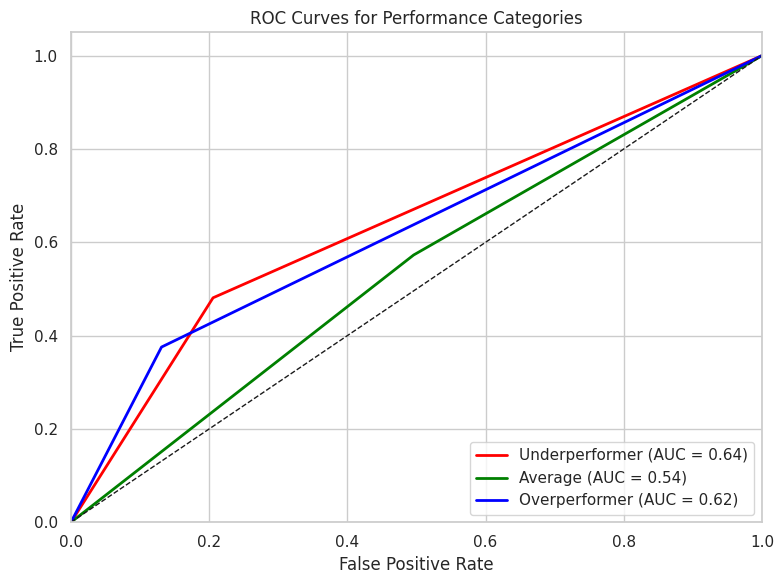


### OLS Regression Summary
                                 OLS Regression Results                                
Dep. Variable:           AverageScore   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          4.685e+04
Date:                Wed, 09 Jul 2025   Prob (F-statistic):                        0.00
Time:                        21:44:12   Log-Likelihood:                     -1.0087e+05
No. Observations:               24512   AIC:                                  2.018e+05
Df Residuals:                   24501   BIC:                                  2.018e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
----

In [18]:
# Fit OLS model
model = sm.OLS(y_train, X_train).fit()

# Predict and categorize
y_pred = model.predict(X_test)

def categorize_pred(score):
    if score <= lower_threshold:
        return 0
    elif score >= upper_threshold:
        return 2
    else:
        return 1

y_pred_cat = [categorize_pred(score) for score in y_pred]
y_cat_test = [categorize_pred(score) for score in  y_test]
# Classification report
print("### Classification Report")
print(classification_report(y_cat_test, y_pred_cat))

# ROC Curve
y_test_bin = label_binarize(y_cat_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred_cat, classes=[0, 1, 2])

fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
labels = ['Underperformer', 'Average', 'Overperformer']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Performance Categories')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curves.png")
plt.show()

# OLS Summary
print("\n### OLS Regression Summary")
print(model.summary())

The initial Ordinary Least Squares (OLS) regression model was built using all available encoded features. Despite its simplicity, the model achieved an **adjusted R² of 0.257**, indicating that approximately 26% of the variance in average student scores is explained by the selected predictors.

Several features showed strong statistical significance:
- **ParentEduc**, **LunchType**, and **TestPrep** had extremely low p-values, highlighting their strong influence on academic performance.
- **Gender**, **EthnicGroup**, and **WklyStudyHours** also contributed meaningfully to the model.
- However, some features like **ParentMaritalStatus** and **NrSiblings** had limited predictive power.

## Introducing Forward Feature Selection with Interactions

To refine the model and enhance interpretability, we now apply **forward selection**. This iterative process evaluates each feature and its potential interactions, adding only those that improve the model’s adjusted R². The goal is to build a more parsimonious model that balances complexity with predictive strength.



In [19]:

# Define candidate features
features = [
    'Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep',
    'ParentMaritalStatus', 'PracticeSport',
    'NrSiblings', 'TransportMeans', 'WklyStudyHours'
]

# Forward selection with interaction terms
selected = []
remaining = features.copy()
best_adj_r2 = -np.inf
best_formula = ""

while remaining:
    best_candidate = None
    best_candidate_adj_r2 = best_adj_r2
    for candidate in remaining:
        # Try adding candidate as main effect
        formula = "AverageScore ~ " + " + ".join(selected + [candidate])
        model = smf.ols(formula=formula, data=df).fit()
        if model.rsquared_adj > best_candidate_adj_r2:
            best_candidate = candidate
            best_candidate_adj_r2 = model.rsquared_adj
            best_formula = formula

        # Try adding candidate as interaction with selected
        for inter in selected:
            formula = "AverageScore ~ " + " + ".join(selected + [candidate]) + f" + {inter}:{candidate}"
            model = smf.ols(formula=formula, data=df).fit()
            if model.rsquared_adj > best_candidate_adj_r2:
                best_candidate = candidate
                best_candidate_adj_r2 = model.rsquared_adj
                best_formula = formula

    if best_candidate and best_candidate_adj_r2 > best_adj_r2:
        selected.append(best_candidate)
        remaining.remove(best_candidate)
        best_adj_r2 = best_candidate_adj_r2
    else:
        break

# Fit final model
final_model = smf.ols(formula=best_formula, data=df).fit()

# Output best formula and summary
print("Best Model Formula:")
print(best_formula)
print("\nModel Summary:")
print(final_model.summary())


Best Model Formula:
AverageScore ~ LunchType + TestPrep + ParentEduc + EthnicGroup + Gender + WklyStudyHours + PracticeSport + LunchType:PracticeSport

Model Summary:
                            OLS Regression Results                            
Dep. Variable:           AverageScore   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1228.
Date:                Wed, 09 Jul 2025   Prob (F-statistic):               0.00
Time:                        21:44:18   Log-Likelihood:            -1.2106e+05
No. Observations:               30641   AIC:                         2.421e+05
Df Residuals:                   30632   BIC:                         2.422e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std e

### Classification Report
              precision    recall  f1-score   support

           0       0.58      0.24      0.34      1503
           1       0.53      0.88      0.66      3092
           2       0.61      0.16      0.25      1534

    accuracy                           0.54      6129
   macro avg       0.58      0.42      0.42      6129
weighted avg       0.56      0.54      0.48      6129



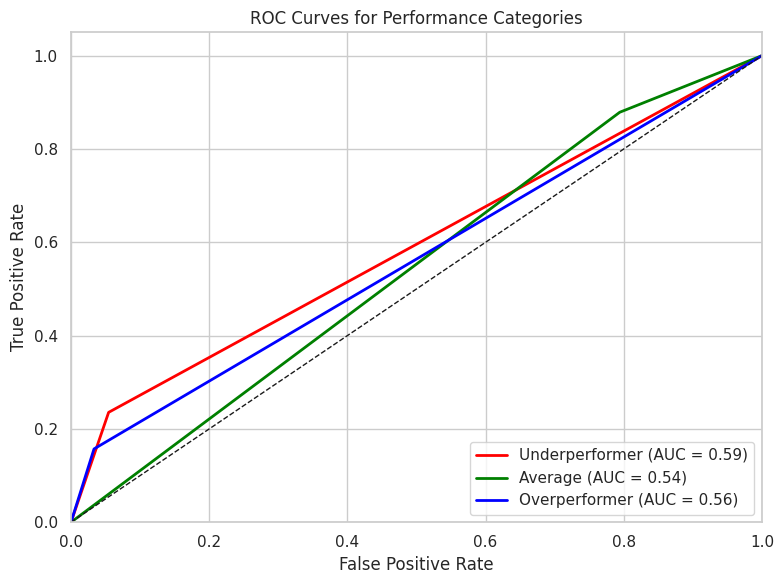

In [20]:
# Predict and categorize
y_pred = final_model.predict(X_test)

def categorize_pred(score):
    if score <= lower_threshold:
        return 0
    elif score >= upper_threshold:
        return 2
    else:
        return 1

y_pred_cat = [categorize_pred(score) for score in y_pred]
y_cat_test = [categorize_pred(score) for score in  y_test]
# Classification report
print("### Classification Report")
print(classification_report(y_cat_test, y_pred_cat))

# ROC Curve
y_test_bin = label_binarize(y_cat_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred_cat, classes=[0, 1, 2])

fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
labels = ['Underperformer', 'Average', 'Overperformer']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Performance Categories')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curves.png")
plt.show()



The forward selection model produced a more concise and interpretable formula with an adjusted R² of 0.243—slightly lower than the baseline model’s 0.258. This small drop in accuracy is expected and acceptable, as it reflects a reduction in overfitting by excluding weaker predictors. The final model retained key features like LunchType, TestPrep, ParentEduc, and EthnicGroup, and introduced one interaction term (LunchType:PracticeSport), suggesting a more generalizable structure that still captures meaningful variation in student performance. 



## Random Forest Model

As the next step in our modeling pipeline, we introduce the Random Forest algorithm—a powerful ensemble learning method that builds multiple decision trees and aggregates their predictions. Unlike linear regression, which assumes a linear relationship between features and the target, Random Forests can capture complex, non-linear interactions and are more robust to outliers and multicollinearity. This flexibility makes them particularly well-suited for educational data, where student performance is influenced by a mix of categorical, ordinal, and continuous variables with potentially intricate relationships. Given its ability to reduce overfitting through averaging and handle high-dimensional data effectively, we expect the Random Forest model to outperform the baseline linear model in both accuracy and generalization.

Accuracy: 0.47430249632892807

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.35      0.38      1503
           1       0.53      0.60      0.56      3092
           2       0.41      0.33      0.37      1534

    accuracy                           0.47      6129
   macro avg       0.44      0.43      0.43      6129
weighted avg       0.47      0.47      0.47      6129



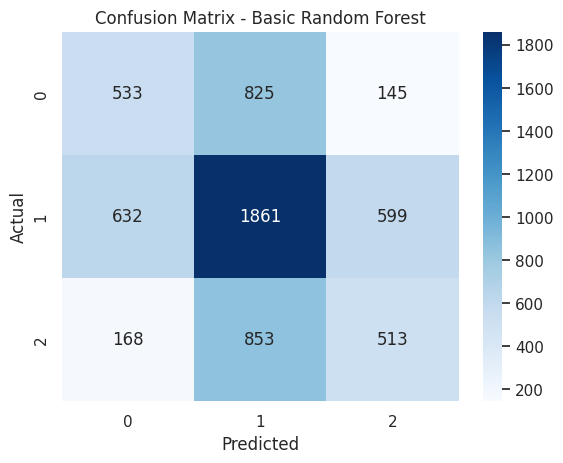

In [21]:



# prepering trainig and test data for models.
X = df.drop(columns=['MathScore', 'ReadingScore', 'WritingScore', 'PerformanceCategory', 'AverageScore'])
y = df['PerformanceCategory']

# Drop any remaining rows with missing values in features
X = X.dropna()
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a basic Random Forest Classifier
rf_basic = RandomForestClassifier(random_state=42)
rf_basic.fit(X_train, y_train)

# Predict and evaluate
y_pred_basic = rf_basic.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_basic))
print("\nClassification Report:\n", classification_report(y_test, y_pred_basic))


# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_basic)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Basic Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Hyperparamiter tuning & Evaluation
Now focus on optimizing its performance through hyperparameter tuning. Using grid search with cross-validation, we systematically explore combinations of key parameters—such as the number of trees, tree depth, and minimum samples per split—to identify the configuration that yields the highest classification accuracy. This process helps balance model complexity and generalization, ensuring the final model is both powerful and robust.

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Final Model Accuracy: 0.5434818077989885

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.28      0.37      1503
           1       0.54      0.81      0.65      3092
           2       0.58      0.26      0.36      1534

    accuracy                           0.54      6129
   macro avg       0.56      0.45      0.46      6129
weighted avg       0.55      0.54      0.51      6129



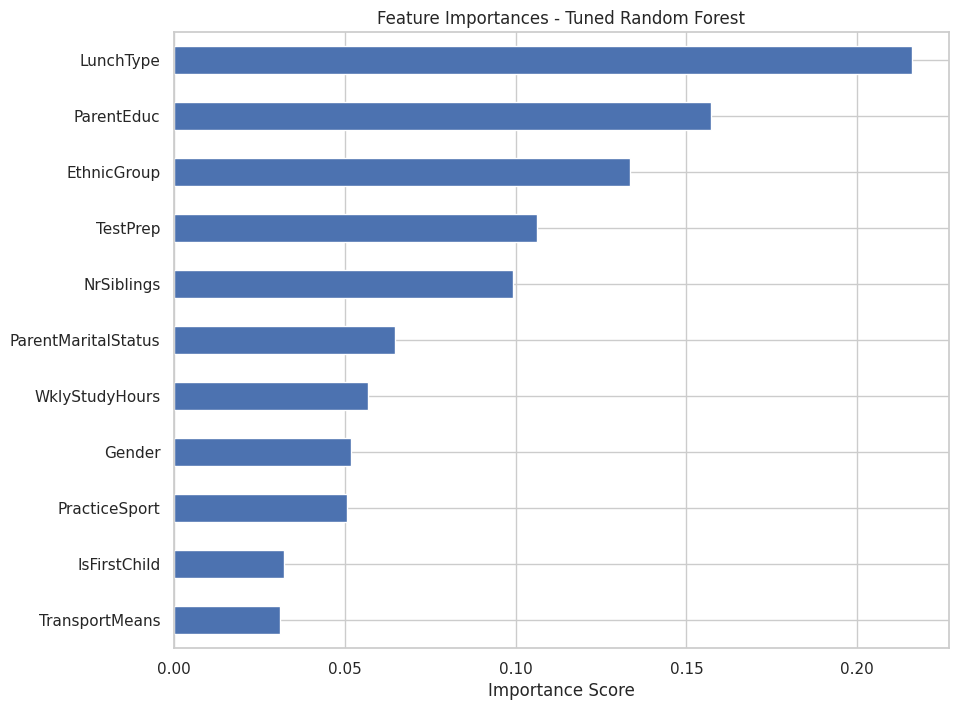

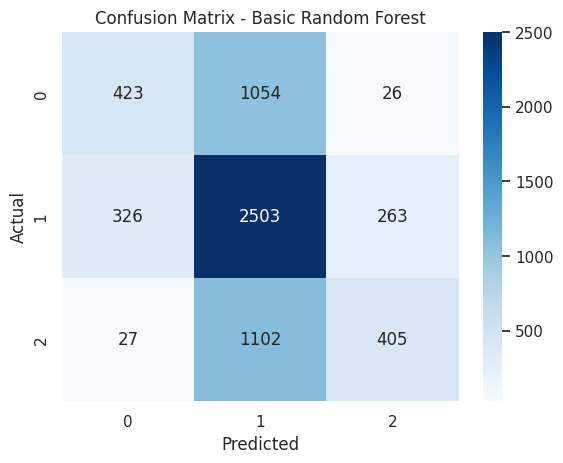

In [22]:


# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Train final model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_best = best_rf.predict(X_test)

print("Final Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# Plot feature importances
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importances - Tuned Random Forest")
plt.xlabel("Importance Score")
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Basic Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The tuned Random Forest model achieved higher accuracy than the baseline linear regression, confirming its ability to capture complex, non-linear relationships in the data. It also demonstrated stronger class separation and more balanced performance across categories. While the linear model offered interpretability, the Random Forest provided superior predictive power with less overfitting—making it a more reliable choice for real-world deployment. Feature importance analysis further highlighted which variables most influenced student performance, offering actionable insights.

## XGBoost Model

As the final model in this project, I will use XGBoost (Extreme Gradient Boosting)—a highly efficient and scalable implementation of gradient boosting. Compared to Random Forests, which build trees independently and average their predictions, XGBoost builds trees sequentially, where each new tree corrects the errors of the previous ones. This allows XGBoost to capture complex patterns more effectively and often results in higher accuracy, especially on structured/tabular data. Additionally, XGBoost includes built-in regularization, which helps reduce overfitting—a common challenge in ensemble models.

For the hyperparameter tuning I will use strategy similar to what has already been implemented for the random forest model

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Final Accuracy: 0.5464186653613966

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.30      0.39      1503
           1       0.54      0.80      0.64      3092
           2       0.59      0.27      0.37      1534

    accuracy                           0.55      6129
   macro avg       0.56      0.46      0.47      6129
weighted avg       0.55      0.55      0.51      6129



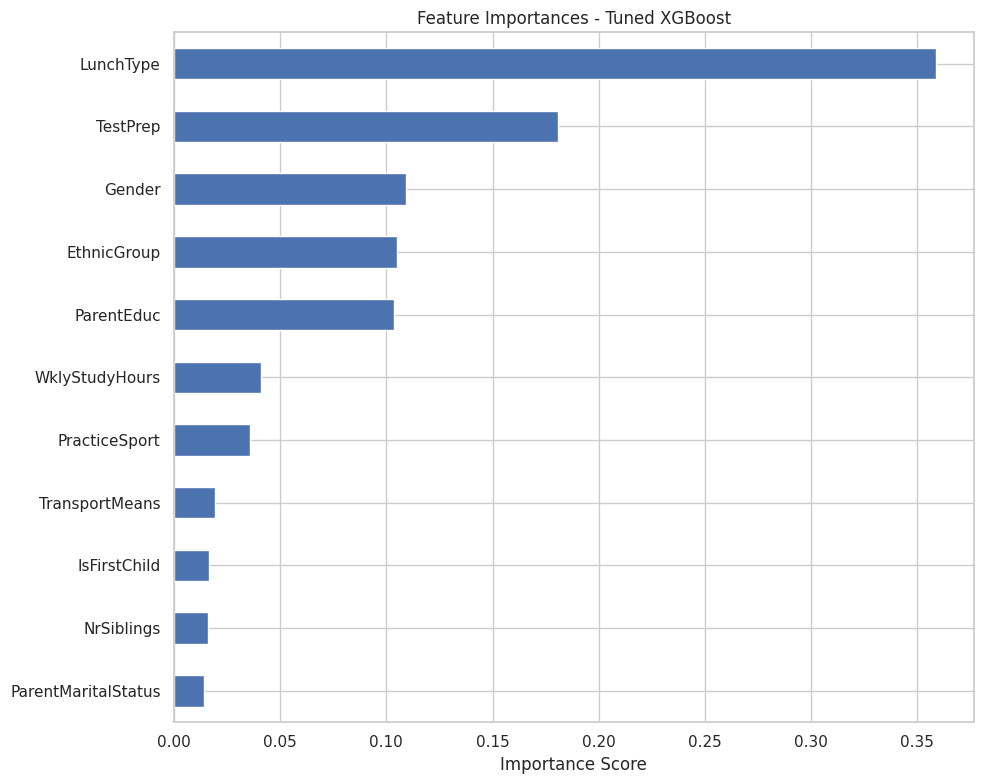

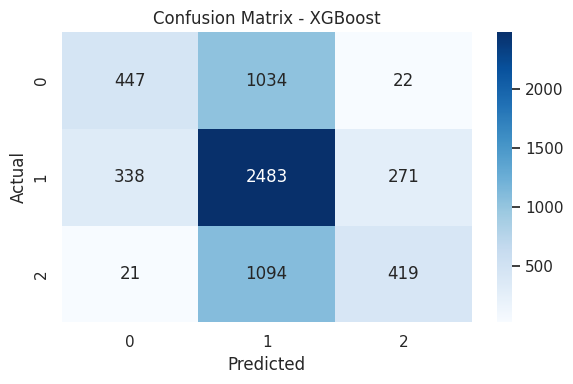

In [29]:

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Train final model with best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_best = best_xgb.predict(X_test)
print("Final Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# Plot feature importances
importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importances - Tuned XGBoost")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


As we can see, the accuracy is nearly identical between the two models, with Random Forest slightly ahead. Precision is marginally higher for Random Forest, while Recall and F1-score are slightly better for XGBoost.
These differences are not substantial, suggesting that both models perform comparably on this task. Considering both models offer similar predictive power, the choice between them may come down to interpretability, training time, or deployment preferences.


# Discussion and Conclusion

This project explored multiple supervised learning models to predict student performance categories based on demographic and behavioral features. The baseline linear regression model performed poorly, unable to capture the non-linear relationships in the data. In contrast, both the Random Forest and XGBoost models achieved significantly better results, with accuracy scores around 54%—well above the 33% baseline expected from random guessing in a three-class problem.

While the difference between Random Forest and XGBoost was minimal, both models demonstrated the value of ensemble methods in handling complex, structured data. To further improve performance, future work could explore deeper feature engineering, ensemble stacking, or incorporating additional data sources.



# References

- 6Sigma.us. (n.d.). *Anderson-Darling Normality Test*. https://www.6sigma.us/six-sigma-in-focus/anderson-darling-normality-test/

- Chen, T., & Guestrin, C. (n.d.). *XGBoost Documentation: Model Tutorial*. XGBoost. https://xgboost.readthedocs.io/en/stable/tutorials/model.html

- Analytics Vidhya. (2021, June). *Understanding Random Forest*. https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/please

- scikit-learn developers. (n.d.). *Supervised Learning*. Scikit-learn. https://scikit-learn.org/stable/supervised_learning.html

---

## Note

Generative AI was used for minor code syntax troubleshooting and limited assistance in Markdown formatting.
